# Recommender Systems

Recommender systems are used to predict the _rating_ or _preference_ that a user would give to an item. This is commonly used to recommend or to suggest products, and other items such as movies, restaurants, friends on social media, music, and etc. to the users.

Broadly speaking, the recommender systems can be classified into 4 types:

* __Simple Recommernders__: which offer generalized recommendations to all the users based on some features of the item. The basic idea behind this system is that most popular items have a higher probability of being liked by an average user.

* __Content-Based Recommenders__: which suggest similar items based on a particular item using the item's metadata. The idea is that a person who liked a specific item would also like similar items.

* __Collaborative Filtering (CF) Engines__: these try to predict the rating or preference that a user would give an item, based on past ratings and preferences of other users. In other words, this method uses the _wisdom of the crowd_ to recommend items. These engines do not need the item meta-data.

* __Hybrid Recommender Systems__: Combining content-based and CF approaches can be more effective in some cases. Hybrid approaches use different techniques for this combinations, such as making predictions separately using each approach and combining the results, adding content-based capabilities to the CF, or by unifying the approaches in one model.

In general the CF approach is more commonly used as it usually gives better results and is relatively easy to understand. The algorithms is able to do feature learning on it own and to learn what features to use.

CF can be devided into:
* __Memory-Based Collaborative Filtering__: This approach uses user rating data to compute the similarity between the users or items. Commonly, _Pearson correlation_ nad _vector cosine_ based similarity measures are used. 
* __Model-Based Collaborative Filtering__: In this approach models are developed using different data mining, machine learning algorithms to predict users' rating of unrated items. Model-based CF algorithms can be _Bayesian Networks_, _Clustering Models_, _Latent Semantic Analysis_ such as, _singular value decomposition_, _probabilistic latent semantic analysis_ and etc.

To get more theoretical details on recommender systems, one of the recommended textbooks is: _Recommender systems by Jannach and Zanker_.

## Content-Based Recommender Systems in Python
Here we would create a content based recommender system on the famous movie lens data set.

Here the data set include the user ID, the item ID, the rating the user has given to a particular item (a movie), and the timestamp.

On another dataset we have the movie titles for each item id that can be found in the previous dataset. We can read these titles are replace the item id in the dataset to have a more meaningful content instead of only numbers for the movies.

### Reading and viewing the dataset

In what follows we are going to read and take a look at the dataset:

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
column_names = ['user_id','item_id','rating','timestamp']

In [3]:
df = pd.read_csv('u.data', sep='\t', names=column_names)

In [4]:
df.head(4)

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949


In [5]:
movie_titles = pd.read_csv('Movie_Id_Titles')

In [6]:
movie_titles.head(4)

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)


Now we will replace the item id with the real movie titles:

In [7]:
df = df.merge(movie_titles, how='inner', on='item_id')

In [8]:
df.head()

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


Now let's make a rating data frame with average rating and number of ratings:

In [9]:
df.groupby('title')['rating'].mean().sort_values(ascending=False).head()

title
Marlene Dietrich: Shadow and Light (1996)     5.0
Prefontaine (1997)                            5.0
Santa with Muscles (1996)                     5.0
Star Kid (1997)                               5.0
Someone Else's America (1995)                 5.0
Name: rating, dtype: float64

Here we should take care that there might be rankings based on few people who have ranked the movie, and viewing the rankings only by the grouping based on the title of the movie can be misleading. Let's take a look at the most rated movies and put it together with the average ratings:

In [10]:
df.groupby('title')['rating'].count().sort_values(ascending=False).head()

title
Star Wars (1977)             584
Contact (1997)               509
Fargo (1996)                 508
Return of the Jedi (1983)    507
Liar Liar (1997)             485
Name: rating, dtype: int64

In [11]:
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings['no. of ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())

In [12]:
ratings.head()

,rating,no. of ratings
title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41


### Exploratory data analysis
Let's explore the data and run some visualizations to study the dataset:

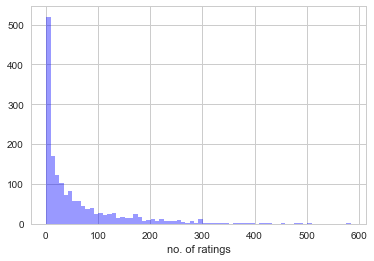

In [13]:
sns.set_style('whitegrid')
sns.distplot(ratings['no. of ratings'], bins=70, kde=False, color='b')

Here we can see that most movies have few ratings, and there are many movies with no ranking. Now let's take a look at the ratings themselves:

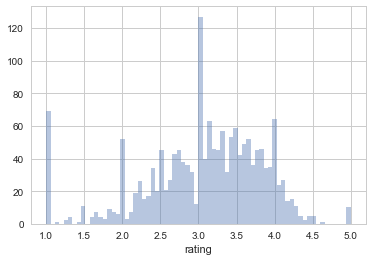

In [14]:
sns.distplot(ratings['rating'], bins=70, kde=False)

As it can be seen on the histogram, there are some picks on whole numbers 1.0, 2.0,...,5.0, which makes sense as people rate movies usually using whole numbers, considering that these movies probably have few or only one ratings which cause them to have whole numbers as the rating.

Another observation is that most movie ratings are distributed between 3.0 - 3.5 stars.

Let's look at the distribution of actual average ratings and the number of ratings:

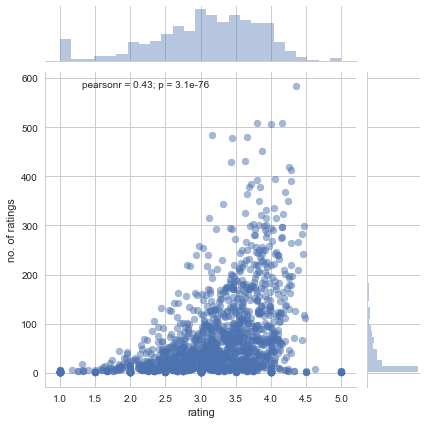

In [16]:
sns.jointplot(ratings['rating'], ratings['no. of ratings'], alpha=0.5)

As it can be seen, the more number of ratings a movie have, the higher the rating. This is because usually good movies will be seen by many people. And we can see that movies with rankings between 1-2 starts have had fewer number of rankings as less poeple have watched them.

## Building the Recommendation System

Now we want to create a simple recommender system based on item similarity. Let's create a pivot table with the ratings that each user has given to a movie:

In [17]:
movie_matrix = pd.pivot_table(index='user_id', columns='title', values='rating', data=df)

In [19]:
movie_matrix.head(3)

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Looking at the pivot table we can see that we have a lot of missing values, as not all users have rated all movies. Let's take a look at two most rated movies and check their similarity to other movies:

In [20]:
ratings.sort_values('no. of ratings', ascending=False).head(10)

,rating,no. of ratings
title,,
Star Wars (1977),4.359589,584
Contact (1997),3.803536,509
Fargo (1996),4.155512,508
Return of the Jedi (1983),4.007890,507
Liar Liar (1997),3.156701,485
"English Patient, The (1996)",3.656965,481
Scream (1996),3.441423,478
Toy Story (1995),3.878319,452
Air Force One (1997),3.631090,431


let's choose two of the most rated from this top 10 list and take a look at their ratings:

In [21]:
starwars_user_ratings = movie_matrix['Star Wars (1977)']
liarliar_user_ratings = movie_matrix['Liar Liar (1997)']

In [22]:
starwars_user_ratings.head()

user_id
0    5.0
1    5.0
2    5.0
3    NaN
4    5.0
Name: Star Wars (1977), dtype: float64

Now we look at the similarity of the movies to starwars by looking at the correlation of the user ratings of every other movie to the starwars movie:

In [23]:
similar_to_starwars = movie_matrix.corrwith(starwars_user_ratings)

C:\Users\Mahsa\Anaconda3\envs\Kaggle\lib\site-packages\numpy\lib\function_base.py:2995: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\Mahsa\Anaconda3\envs\Kaggle\lib\site-packages\numpy\lib\function_base.py:2929: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


In [24]:
similar_to_liarliar = movie_matrix.corrwith(liarliar_user_ratings)

C:\Users\Mahsa\Anaconda3\envs\Kaggle\lib\site-packages\numpy\lib\function_base.py:2995: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\Mahsa\Anaconda3\envs\Kaggle\lib\site-packages\numpy\lib\function_base.py:2929: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


In [25]:
corr_starwars = pd.DataFrame(similar_to_starwars, columns=['Correlation'])
corr_starwars.dropna(inplace=True)

In [26]:
corr_starwars.head()

,Correlation
title,
'Til There Was You (1997),0.872872
1-900 (1994),-0.645497
101 Dalmatians (1996),0.211132
12 Angry Men (1957),0.184289
187 (1997),0.027398


Here we can see how correlated are the movies user ratings are to the user ratings of the Star Wars movie. Therefore if we sort this list, we should be able to see most similar movies in sense of the user ratings to the Star Wars, however we should make sure not to consider the movies with few number of ratings:

In [28]:
corr_starwars.sort(columns=['Correlation'], ascending=False).head(10)

C:\Users\Mahsa\Anaconda3\envs\Kaggle\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  """Entry point for launching an IPython kernel.


,Correlation
title,
Commandments (1997),1.0
Cosi (1996),1.0
No Escape (1994),1.0
Stripes (1981),1.0
Man of the Year (1995),1.0
Hollow Reed (1996),1.0
"Beans of Egypt, Maine, The (1994)",1.0
"Good Man in Africa, A (1994)",1.0
"Old Lady Who Walked in the Sea, The (Vieille qui marchait dans la mer, La) (1991)",1.0


We can see that many movies in this list are not very famous. We filter out the movies with less than 100 ratings to have a more meaningful similarity list:

In [29]:
corr_starwars = corr_starwars.join(ratings['no. of ratings'])

In [30]:
corr_starwars.head(3)

,Correlation,no. of ratings
title,,
'Til There Was You (1997),0.872872,9
1-900 (1994),-0.645497,5
101 Dalmatians (1996),0.211132,109


In [31]:
corr_starwars_filtered = corr_starwars[corr_starwars['no. of ratings']>100]

In [33]:
corr_starwars_filtered.sort(['Correlation'], ascending=False).head(10)

C:\Users\Mahsa\Anaconda3\envs\Kaggle\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  """Entry point for launching an IPython kernel.


,Correlation,no. of ratings
title,,
Star Wars (1977),1.000000,584
"Empire Strikes Back, The (1980)",0.748353,368
Return of the Jedi (1983),0.672556,507
Raiders of the Lost Ark (1981),0.536117,420
Austin Powers: International Man of Mystery (1997),0.377433,130
"Sting, The (1973)",0.367538,241
Indiana Jones and the Last Crusade (1989),0.350107,331
Pinocchio (1940),0.347868,101
"Frighteners, The (1996)",0.332729,115


We can see that the highly correlated movies are quite similar to the original movie. Here we should know that the correlation is based on the popularity of the movies and not their content. And the logic is that if someone has liked a popular movie they would probably like also another popular movie. 

Let's explore the results for the Liar Liar to see if we get different results:

In [38]:
corr_liarliar = pd.DataFrame(similar_to_liarliar, columns=['Correlation'])
corr_liarliar.dropna(inplace=True)

In [40]:
corr_liarliar = corr_liarliar.join(ratings['no. of ratings'])

In [42]:
corr_liarliar_filtered = corr_liarliar[corr_liarliar['no. of ratings']>100]

In [43]:
corr_liarliar_filtered.sort('Correlation', ascending=False).head(10)

C:\Users\Mahsa\Anaconda3\envs\Kaggle\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  """Entry point for launching an IPython kernel.


,Correlation,no. of ratings
title,,
Liar Liar (1997),1.000000,485
Batman Forever (1995),0.516968,114
"Mask, The (1994)",0.484650,129
Down Periscope (1996),0.472681,101
Con Air (1997),0.469828,137
Pretty Woman (1990),0.469790,164
101 Dalmatians (1996),0.469765,109
Michael (1996),0.442022,119
Waterworld (1995),0.438405,102


Also here we can see the movies that are similar to the Liar Liar. As the number of ratings decreases we will get lower correlations. It's a good idea to play with our filter threshold to get better results.